In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

# Train data

In [2]:
root_dir = Path('/home/lang/Projects/Hecktor2021/challenge_data/data/')

In [3]:
surv_training_df = pd.read_csv(root_dir / 'hecktor2021_train/hecktor2021_patient_endpoint_training.csv')
cols = {
    'PatientID': 'identifier',
    'Progression': 'event',
    'Progression free survival': 'time'
}
surv_training_df = surv_training_df.rename(columns=cols)

In [4]:
clin_training_df = pd.read_csv(root_dir / 'hecktor2021_train/hecktor2021_patient_info_training.csv')

In [5]:
columns = {
    'PatientID': 'identifier',
    'PatientID_hecktor': 'identifier',
    'CenterID': 'center',
    'Gender (1=M,0=F)': 'gender',
    'Age': 'age',
    'Tobacco': 'tobacco',
    'Alcohol': 'alcohol',
    'Performance status': 'performance',
    'TNM edition': 'tnm_edition',
    'TNM group': 'tnm_stage',
    'T-stage': 't_stage',
    'N-stage': 'n_stage',
    'M-stage': 'm_stage',
    'HPV status (0=-, 1=+)': 'hpv_status',
    'Chemotherapy': 'chemo',
    'Estimated weight (kg) for SUV': 'suv_weight'
}

In [6]:
clin_training_df = clin_training_df.rename(columns=columns)

In [7]:
training_df = surv_training_df.merge(clin_training_df, how='left')

In [8]:
def to_cat(series, na_action):
    dic = {}
    keys = sorted(series.value_counts().keys())
    for val, key in enumerate(keys):
        dic[key] = val
    return series.map(dic, na_action=na_action)

In [9]:
for col in ['t_stage', 'n_stage', 'm_stage', 'tnm_stage']:
    training_df[col] = to_cat(training_df[col], 'ignore')

In [10]:
training_df['split'] = (
    1000*training_df['chemo'].fillna(2) +
    100*training_df['center'].fillna(0) +
    10*training_df['hpv_status'].fillna(2) +
    training_df['event']
)

cut_split = {}
for key, value in training_df['split'].value_counts().iteritems():
    if value < 5:
        cut_split[key] = -1

training_df['split'] = training_df['split'].replace(cut_split)

In [11]:
training_df = training_df.fillna(-1)

In [12]:
split_size = 0.15
split = StratifiedShuffleSplit(n_splits=1, test_size=split_size, random_state=42)

for train_idx, valid_idx in split.split(training_df, training_df['split']):
    train_df = training_df.iloc[train_idx]
    valid_df = training_df.iloc[valid_idx]

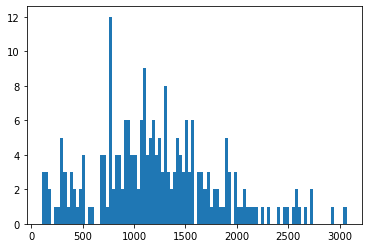

In [13]:
_ = plt.hist(training_df['time'].values, bins=100)

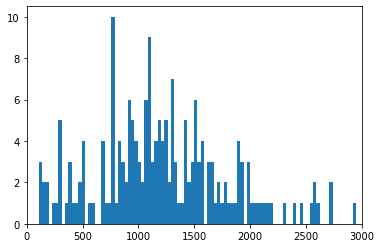

In [14]:
_ = plt.hist(train_df['time'].values, bins=100)
_ = plt.xlim([0, 3000])

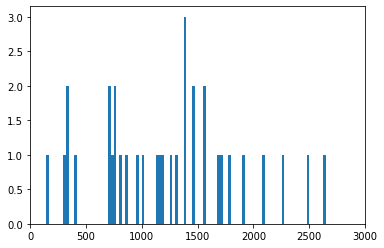

In [15]:
_ = plt.hist(valid_df['time'].values, bins=100)
_ = plt.xlim([0, 3000])

# Test

In [16]:
clin_test_df = pd.read_csv(root_dir / 'hecktor2021_test/hecktor2021_patient_info_testing.csv')

In [17]:
test_df = clin_test_df.rename(columns=columns)

In [18]:
for col in ['t_stage', 'n_stage', 'm_stage', 'tnm_stage']:
    test_df[col] = to_cat(test_df[col], 'ignore')

In [19]:
test_df = test_df.fillna(-1)

# Save

In [20]:
to_disk = False
if to_disk:            
    save_path = root_dir / 'label/split'
    save_path.mkdir(parents=True, exist_ok=True)
    
    training_df.to_csv(
        save_path.parent / 'training.csv',
        index=False
    )
    test_df.to_csv(
        save_path.parent / 'test.csv',
        index=False
    )

    train_df.to_csv(save_path / 'train.csv', index=False)
    valid_df.to_csv(save_path / 'valid.csv', index=False)